In [51]:
import os
os.chdir('/Users/bnowacki/Documents/Git Repositories/rapid-soh-estimation-from-short-pulses')

from rapid_soh_estimation.rapid_soh_estimation.config import *
from rapid_soh_estimation.rapid_soh_estimation.common_methods import *

In [ ]:

df = load_processed_data(get_preprocessed_data_files(data_type='rpt', cell_id=2))

plt.figure(figsize=(4,3))
for rpt_num in sorted(df['RPT Number'].unique()):
	df_filt = df.loc[(df['Segment Key'] == 'slowpulse') & \
					(df['Pulse Type'] == 'chg') & \
					(df['Pulse SOC'] == 20) & \
					(df['RPT Number'] == rpt_num)]
	plt.plot(df_filt['Time (s)'].values - df_filt['Time (s)'].values[0], 
			 df_filt['Voltage (V)'], '.')
plt.show()
print("All RPTs: ", sorted(df['RPT Number'].unique()))

In [ ]:
df = load_processed_data(get_preprocessed_data_files(data_type='cycling', cell_id=2))

plt.figure(figsize=(4,3))
for week_num in sorted(df['Week Number'].unique()):
	df_filt = df.loc[(df['Week Number'] == week_num)]
	plt.plot(df_filt['Time (s)'], df_filt['Voltage (V)'], '-')
plt.xlim([-1000,40000])
plt.show()

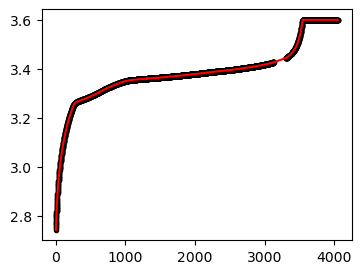

In [92]:
rpt_data = load_processed_data(get_preprocessed_data_files(data_type='rpt', cell_id=2))


plt.figure(figsize=(4,3))
for rpt_num in sorted(rpt_data['RPT Number'].unique())[0:1]:
    df_chg_p1 = rpt_data.loc[(rpt_data['RPT Number'] == rpt_num) & \
							 (rpt_data['Segment Key'] == 'ref_chg') & \
							 (rpt_data['Step Number'] == 50)]
    df_chg_p2 = rpt_data.loc[(rpt_data['RPT Number'] == rpt_num) & \
							 (rpt_data['Segment Key'] == 'ref_chg') & \
							 (rpt_data['Step Number'] == 54)]
    chg_p1_v = df_chg_p1['Voltage (V)'].values
    chg_p1_t = df_chg_p1['Time (s)'].values - df_chg_p1['Time (s)'].values[0]
    chg_p2_v = (df_chg_p2['Voltage (V)'].values)[120:]
    chg_p2_t = (df_chg_p2['Time (s)'].values - df_chg_p1['Time (s)'].values[0])[120:]
    
    chg_t_interp = np.arange(chg_p1_t[0], chg_p2_t[-1], 1)
    chg_v_interp = np.interp(chg_t_interp, np.hstack([chg_p1_t, chg_p2_t]), np.hstack([chg_p1_v, chg_p2_v]))
    
    plt.plot(chg_p1_t, chg_p1_v, 'k.')
    plt.plot(chg_p2_t, chg_p2_v, 'k.')
    plt.plot(chg_t_interp, chg_v_interp, 'r-')
plt.show()

In [116]:

# process RPT data --> extract pulse voltage, current, and time
pulse_dic = {
	'20soc': {
		'charge_pulse': {'cell_id':[], 'group_id':[], 'rpt':[], 'time':[], 'voltage':[], 'current':[], 'q_dchg':[],},
		'discharge_pulse': {'cell_id':[], 'group_id':[], 'rpt':[], 'time':[], 'voltage':[], 'current':[], 'q_dchg':[],},
	},
	'50soc': {
		'charge_pulse': {'cell_id':[], 'group_id':[], 'rpt':[], 'time':[], 'voltage':[], 'current':[], 'q_dchg':[],},
		'discharge_pulse': {'cell_id':[], 'group_id':[], 'rpt':[], 'time':[], 'voltage':[], 'current':[], 'q_dchg':[],},
	},
	'90soc': {
		'charge_pulse': {'cell_id':[], 'group_id':[], 'rpt':[], 'time':[], 'voltage':[], 'current':[], 'q_dchg':[],},
		'discharge_pulse': {'cell_id':[], 'group_id':[], 'rpt':[], 'time':[], 'voltage':[], 'current':[], 'q_dchg':[],},
	},
}
cell_id = 2
group_id = int(((cell_id - 2) / 6) + 1)
for rpt_num in sorted(rpt_data['RPT Number'].unique()):
	#region: extract q_dchg data
	df_dchg = rpt_data.loc[(rpt_data['RPT Number'] == rpt_num) & \
						    (rpt_data['Segment Key'] == 'ref_dchg')]
	q_dchg = df_dchg['Capacity (Ah)'].values[-1]
	#endregion
	for soc in [20,50,90]:
		for p_type in ['chg', 'dchg']:
			#region: extract slowpulse data
			# filter dataframe to current slow pulse (using RPT number, SOC, pulse type)
			df_pulse = rpt_data.loc[(rpt_data['RPT Number'] == rpt_num) & \
										(rpt_data['Segment Key'] == 'slowpulse') & \
										(rpt_data['Pulse SOC'] == soc) & \
										(rpt_data['Pulse Type'] == p_type)]
			
			# split pulse into three segments and interpolated to expected lengths (in seconds)
			seg_lengths = [30,10,60]
			seg_ts = []
			seg_vs = []
			seg_is = []
			for i, step in enumerate(df_pulse['Step Number'].unique()):
				df_seg = df_pulse.loc[df_pulse['Step Number'] == step]

				t = df_seg['Time (s)'].values - df_seg['Time (s)'].values[0]
				t_interp = np.arange(0, seg_lengths[i], 1)
				f_v = interpolate.PchipInterpolator(t, df_seg['Voltage (V)'].values)
				f_i = interpolate.PchipInterpolator(t, df_seg['Current (A)'].values)
				v_interp = f_v(t_interp)
				i_interp = f_i(t_interp)

				seg_ts.append(t_interp)
				seg_vs.append(v_interp)
				seg_is.append(i_interp)
		
			pulse_t = np.hstack([seg_ts[0], seg_ts[1]+seg_ts[0][-1], seg_ts[2]+seg_ts[1][-1]+seg_ts[0][-1]])
			pulse_v = np.hstack(seg_vs)
			pulse_i = np.hstack(seg_is)
			assert len(pulse_t) == len(pulse_v) and len(pulse_t) == len(pulse_i)
			#endregion

			pulse_type_key = 'charge_pulse' if p_type == 'chg' else 'discharge_pulse'
			pulse_dic[f'{soc}soc'][pulse_type_key]['cell_id'].append(cell_id)
			pulse_dic[f'{soc}soc'][pulse_type_key]['group_id'].append(group_id)
			pulse_dic[f'{soc}soc'][pulse_type_key]['rpt'].append(rpt_num)
			pulse_dic[f'{soc}soc'][pulse_type_key]['time'].append(pulse_t)
			pulse_dic[f'{soc}soc'][pulse_type_key]['voltage'].append(pulse_t)
			pulse_dic[f'{soc}soc'][pulse_type_key]['current'].append(pulse_t)
			pulse_dic[f'{soc}soc'][pulse_type_key]['q_dchg'].append(q_dchg)



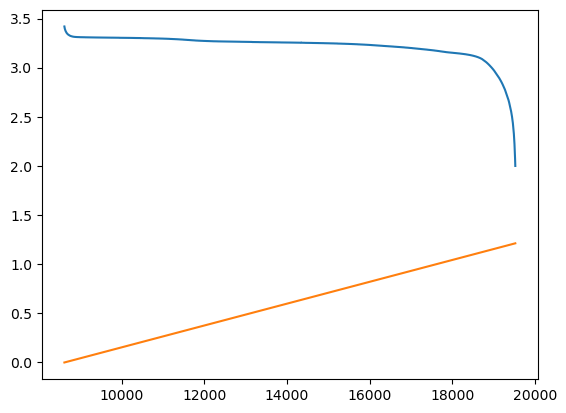

In [112]:
df_dchg = rpt_data.loc[(rpt_data['RPT Number'] == rpt_num) & \
					   (rpt_data['Segment Key'] == 'ref_dchg')]

plt.plot(df_dchg['Time (s)'], df_dchg['Voltage (V)'])
plt.plot(df_dchg['Time (s)'], df_dchg['Capacity (Ah)'])
plt.show()